<font color='tomato'><font color="#CC3D3D"><p>
# This model has the following characteristics:
* No feature engineering
* Applying BOW to raw transactions
* Applying Autoencoder to reduce the number of features

<img align='left' src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" width=700 height=500>

In [ ]:
# 뉴럴넷의 PCA 역할을 하는 것이 autoEncoder이다.
# 훨씬 자유도가 높다
# 입력 뉴런이 100개면 -> 출력뉴런의 수도 100개여야함
# 중간의 히든레이어의 뉴런의 수가 입력뉴런보다 작아야함.
# 100개 들어가면 히든에서 적어졋다가 다시 출력에서 100개로
# 가운데 층이 입력층보다 피쳐가 더 작아 -> 압축된 값이다.
# 가운데가 PCA처럼 차원이 축소된 값이 될 것이다.
# 가운데로 바꾸는 것을 encoder 출력할때 다시 바꿔주는 것을 decoder
# 입력을 어느정도 차원이 작은 쪽으로 만드는 것 encdeor
# 다시 원래대로 만드는 과정이 decoder
#

In [3]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#tf.logging.set_verbosity(tf.logging.ERROR)

#from tensorflow import set_random_seed
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Read Data

In [4]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Transform Categorical Data using BOW

In [5]:
# 구매건수 BOW 만들어서 옆으로 다 붙인 것 -> 화끈하게 압축시칼라 하는 것
# PCA할때 혜리가 스토어 지점넣어서 PCA 돌린 것과 같은 개념
# 오토인코더는 sparse한 데이터에 먹힌다 PCA와 비슷함
# 

level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

### Reduce Dimensionality using Autoencoder

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4179)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2140160   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3302

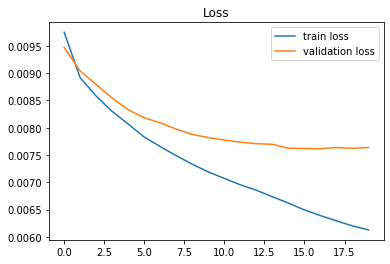

In [6]:
# encoding_dim이 가운데 히든레이어 차원을 몇차원으로 할 것이냐 하는 것


# Define the number of features
max_features = train.shape[1]

# Define the encoder dimension
encoding_dim = 128

# Input Layer
input_dim = Input(shape = (max_features, )) # 피쳐가 얼마나

# Encoder Layers
encoded1 = Dense(512, activation = 'relu')(input_dim) # 층 쌓기: 뉴런이 512개
encoded2 = Dense(256, activation = 'relu')(encoded1) # activation함수를 relu를 씀
encoded3 = Dense(128, activation = 'relu')(encoded2) # activation함수 다른거로 바꿔도 됨
encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3) # <- 압축된 부분, 차원축소된 부분
# 전형적인 모습: 입력뉴런이 굉장히 크다가 점점 줄음. 반씩 줄여감
# 64보다 128이 나아서 128로 함 보통 이렇게 함
# 그다음 다시 늘림. 줄여가는 과정이 encoder 늘려가는게 decoder

# Decoder Layers
decoded1 = Dense(128, activation = 'relu')(encoded4)
decoded2 = Dense(256, activation = 'relu')(decoded1)
decoded3 = Dense(512, activation = 'relu')(decoded2)
decoded4 = Dense(max_features, activation = 'linear')(decoded3)
# 마지막에 입력층하고 값이 같아야 함. 그래서 최종 뉴런이 max_features임
# activation을 linear쓰기도하고 sortmax쓰기도 함
# 

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded4)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse')
# 아담, linear써서 mse를 씀, softmax를 쓰면 binary crossentropy씀


# Train the model
history = autoencoder.fit(train, train, epochs=20, batch_size=64, 
                          shuffle=True, validation_data=(test,test))
# X하고 y가 똑같음. 입력값과 출력값이 같아야함. train, train
# 셔플은 epoch끝날땓마다 셔플을 할꺼냐 안할꺼냐
# validation_data로 쓸꺼냐.
# 자체가 비지도 학습이어서 쓰는대로 들어감. 예측해야할 레이블이 없다
# early stop 안썻는데 써도 됨.
# loss가 떨어지면 잘 하고 있는 것

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

# 

In [7]:
# 중간에 차원축소된 부분을 뽑아낼수가 있음
# model = Model(inputs=input_dim, outputs=act) 인풋을 냅두고 아웃풋을 바꿈
# 4000몇개 들어갓을 때 압축된 피쳐를 쓰겟다는 것 PCA된 거라 생각
# 소스코드는 복잡한데 가운데 코드가 제일 좋더라

# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [encoded4] #[encoded1, encoded2, encoded3, decoded1, decoded2]
for ix, act in enumerate(hidden_act):
    model = Model(inputs=input_dim, outputs=act)
    if ix == 0: 
        X_train = model.predict(train)
        X_test = model.predict(test)
    else:
        X_train = np.hstack([X_train, model.predict(train)])
        X_test = np.hstack([X_test, model.predict(test)])
        
X_train.shape, X_test.shape

((3500, 128), (2482, 128))

### Build Models

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 86us/step -

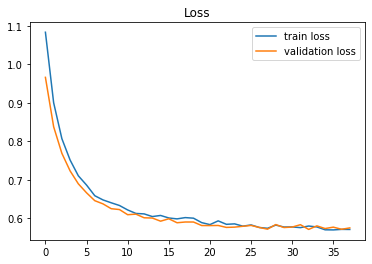

In [8]:
# 뽑아낸 애 가지고 다시 뉴럴넷 학습한것
# W2V의 상위권에 있는 정확도가 나옴. 오토 인코더의 피쳐 압축정도가 좋다.
# 

# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(max_features,), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Train the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Make Submissions

In [7]:
pred = model.predict(X_test)[:,0]
t = pd.Timestamp.now()
fname = f"ae_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'ae_submission_06091004.csv' is ready to submit.


- 노이즈를 넣었는데 성능이 더 잘 나오더라
- 입력 다음에 드롭아웃을 넣어서 학습시켜서 노이스가 들어가서 성능이 좋다
- 밑에꺼 하면 더 잘 나올 것임
- 케라스에 보면 가우시안 노이즈가 잇음

<font color='blue'><p>
### 추가 고려사항
- Denoising Autoencoder (DAE)가 더 성능이 좋다고 알려져 있음 
- DAE 구현방식         
<img align='left' src='https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile24.uf.tistory.com%2Fimage%2F992860505BDC99320A2AA2'>  

 - 오토 인코더 중에 스파스 인코더가 잇음
 - 학습하는 과정에서 L1을 쓰게 되면
     1. weight 규제화
     2. 출력값 규제화 <- 뉴런이 출력되는 것을 끊을 수가 있음
 - 순수하게 쓰는 것보다 성능이 조금더 잘 나온다가 밝혀진 사실
 - AE가 PCA보다 더 강력한 방법인것

<font color='blue'><p>
- Sparse Autoencoder: L1 Activity Regularization 사용       
<img align='left' src='https://miro.medium.com/max/1400/1*k9RX5_kDYt2kG0u9ZREu5w.png' width=600>    

<font color='tomato'><font color="#CC3D3D"><p>
# End